# CMC-15 - Lab 1

Importando pacotes:

In [1]:
from constants import OBSTACLES, WIDTH, HEIGHT
from math import sqrt
from typing import Tuple, Union, List
import heapq
import numpy as np
import matplotlib.pyplot as plt

## Questão 1

Inicializando o mapa:

In [2]:
table = np.ones((HEIGHT, WIDTH))

In [3]:
table[OBSTACLES] = -1.0

In [4]:
unaccesible_cells = table < 0.0

In [5]:
def is_index_valid(i: int, j: int):
    return 0 <= i < HEIGHT and 0 <= j < WIDTH

def get_successors(i: int, j: int):
    if i < 0 or j < 0:
        raise ValueError("Invalid indexes")
    successors = []
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if (di != 0 and dj != 0) or (di == 0 and dj == 0):
                continue
            if is_index_valid(i + di, j + dj) and not unaccesible_cells[i + di, j + dj]:
                successors.append((i + di, j + dj))
    return successors

In [6]:
class Node:
    def __init__(self, i: int, j: int):
        """
        Creates a node of a graph used for planning paths.

        :param i: row of the node in the occupancy grid.
        :type i: int.
        :param j: column of the node in the occupancy grid.
        :type j: int.
        """
        self.i = i
        self.j = j
        self.f = np.inf
        self.g = np.inf
        self.closed = False
        self.parent: Union[Node, None] = None

    def get_position(self) -> Tuple[int, int]:
        """
        Obtains the position of the node as a tuple.

        :return: (i, j) where i is the row and the column of the node, respectively.
        :rtype: 2-dimensional tuple of int.
        """
        return self.i, self.j

    def set_position(self, i, j):
        """
        Sets the position of this node.

        :param i: row of the node in the occupancy grid.
        :type i: int.
        :param j: column of the node in the occupancy grid.
        :type j: int.
        """
        self.i = i
        self.j = j

    def distance_to(self, i: int, j: int) -> float:
        """
        Computes the distance from this node to the position (i, j).

        :param i: row of the target position.
        :type i: int.
        :param j: column of the target position.
        :type j: int.
        :return: distance from this node to (i, j).
        :rtype: float.
        """
        return sqrt((self.i - i) ** 2 + (self.j - j) ** 2)

    # for node < another_node
    def __lt__(self, another_node):
        return (self.i < another_node.i) or (self.j < another_node.j)

In [7]:
node_grid = np.empty(table.shape, dtype=Node)
for i in range(table.shape[0]):
    for j in range(table.shape[1]):
        node_grid[i, j] = Node(i, j)

In [8]:
def get_edge_cost(node: Node, successor: Node) -> float:
    return (table[node.get_position()] + table[successor.get_position()]) / 2.0

def reconstruct_path(end_node: Node):
    node = end_node
    reversed_path = []
    while node is not None:
        reversed_path.append(node.get_position())
        node = node.parent
    return reversed_path[::-1]

In [9]:
def a_star(start_position: Tuple[int, int], end_position: Tuple[int, int], node_grid: np.ndarray):
    node: Node = node_grid[start_position]
    node.g = 0
    node.f = node.g + node.distance_to(*end_position)
    pq: List[Tuple[float, Node]] = []
    heapq.heappush(pq, (node.f, node))

    while pq:
        (f, node) = heapq.heappop(pq)
        if not node.closed:
            node.closed = True
            
            if end_position == node.get_position():
                break
            
            for successor_t in get_successors(node.i, node.j):
                successor: Node = node_grid[successor_t]
                if successor.f > node.g + get_edge_cost(node, successor) + successor.distance_to(*end_position):
                    successor.g = node.g + get_edge_cost(node, successor)
                    successor.f = successor.g + successor.distance_to(*end_position)
                    successor.parent = node
                    heapq.heappush(pq, (successor.f, successor))

    end_node: Node = node_grid[end_position]

    return reconstruct_path(end_node), end_node.g

In [10]:
path, g = a_star((0, 0), (20, 23), node_grid)

[(0, 1), (1, 0)]
[(0, 0), (0, 2), (1, 1)]
[(0, 0), (1, 1), (2, 0)]
[(0, 1), (0, 3), (1, 2)]
[(0, 1), (1, 0), (1, 2), (2, 1)]
[(1, 0), (2, 1), (3, 0)]
[(0, 2), (0, 4), (1, 3)]
[(0, 2), (1, 1), (1, 3), (2, 2)]
[(1, 1), (2, 0), (2, 2), (3, 1)]
[(0, 3), (1, 2)]
[(0, 3), (0, 5)]
[(2, 0), (3, 1)]
[(1, 2), (2, 1), (3, 2)]
[(2, 1), (3, 0), (3, 2)]
[(0, 4), (0, 6), (1, 5)]
[(2, 2), (3, 1), (4, 2)]
[(0, 5), (1, 6), (2, 5)]
[(0, 5), (0, 7), (1, 6)]
[(3, 2), (4, 3), (5, 2)]
[(1, 5), (2, 4), (2, 6)]
[(0, 6), (1, 5), (1, 7), (2, 6)]
[(4, 2), (4, 4), (5, 3)]
[(0, 6), (0, 8), (1, 7)]
[(1, 6), (2, 5), (2, 7), (3, 6)]
[(4, 2), (5, 1), (5, 3), (6, 2)]
[(0, 7), (1, 6), (1, 8), (2, 7)]
[(4, 3), (4, 5), (5, 4)]
[(0, 7), (0, 9), (1, 8)]
[(4, 3), (5, 2), (5, 4), (6, 3)]
[(2, 6), (3, 7), (4, 6)]
[(4, 4), (4, 6), (5, 5)]
[(1, 7), (2, 6), (2, 8), (3, 7)]
[(0, 8), (1, 7), (1, 9), (2, 8)]
[(4, 4), (5, 3), (5, 5), (6, 4)]
[(5, 2), (6, 1), (6, 3)]
[(2, 7), (3, 6), (4, 7)]
[(3, 6), (4, 5), (4, 7), (5, 6)]
[(5, 3), (6

In [15]:
for tup in path:
    table[tup] += 1

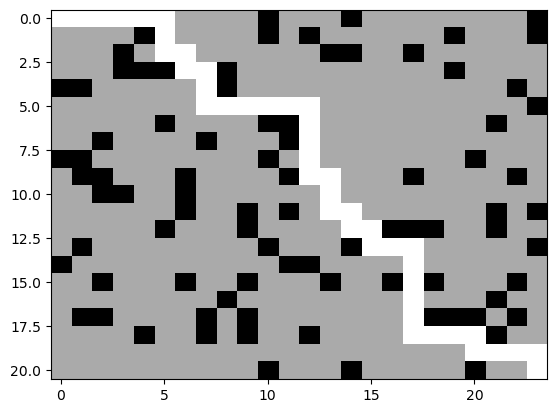

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(table, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')

## Questão 2

In [22]:
from constraint import *
import numpy as np

# Setup Problem
problem = Problem()

In [23]:
# Setup board
N = 7
board = np.array([[0 for j in range(N)] for i in range(N)])



LEGEND FOR THE SETUP OF THE BLACK BOXES:

- number 5 indicates a black box without number on top (number 0 was already being used to indicated if a white cell has a light on it or not)

- number 6 indicates a black box with 0 on top, meaning 0 lights surrounds it (number 0 was already being used to indicated if a white cell has a light on it or not)

- number 7 indicates a black box with 1 on top, meaning 1 light surround it (number 1 was already being used to indicated if a white cell has a light on it or not)

- number 2 indicates a black box with 2 on top, meaning 2 lights surround it

- number 3 indicates a black box with 3 on top, meaning 3 lights surround it


## Test boards available
- Orientation: run only the board you want to play with in that round


In [8]:
# Board 1
# board[1][3] = 6
# board[1][4] = 2

# board[2][1] = 7

# board[3][1] = 6
# board[3][5] = 6

# board[4][5] = 5

# board[5][2] = 5
# board[5][3] = 3

In [17]:
# Board 2
# board[0][2] = 6
# board[0][5] = 5

# board[1][0] = 5
# board[1][4] = 5

# board[2][1] = 2
# board[2][6] = 6

# board[3][3] = 7

# board[4][0] = 7
# board[4][5] = 5

# board[5][2] = 7
# board[5][6] = 3

# board[6][1] = 6
# board[6][4] = 5

In [24]:
# Board 3
# board[0][3] = 2

# board[1][2] = 5
# board[1][4] = 7

# board[2][1] = 5
# board[2][5] = 6

# board[3][0] = 6
# board[3][3] = 3
# board[3][6] = 5

# board[4][1] = 7
# board[4][5] = 2

# board[5][2] = 5
# board[5][4] = 5

# board[6][3] = 7

## Funções auxiliares da CONSTRAINT 1


In [25]:
def verifyLeftBox(board, position):
    # check column
    if position[1] > 0:
        if board[position[0]][position[1] - 1] == 0:
            return True  # Empty box
        else:
            return False  # Black box
    # If its out of index
    else:
        return False


def verifyUpperBox(board, position):
    # check row
    if position[0] > 0:
        if board[position[0] - 1][position[1]] == 0:
            return True  # Empty box
        else:
            return False  # Black box
    # If its out of index
    else:
        return False


def verifyRightBox(board, position):
    # check column N is board size
    if position[1] + 1 < N:
        if board[position[0]][position[1] + 1] == 0:
            return True  # Empty box
        else:
            return False  # Black box
    # If its out of index
    else:
        return False


def verifyBottomBox(board, position):
    # check row N is board size
    if position[0] + 1 < N:
        if board[position[0] + 1][position[1]] == 0:
            return True  # Empty box
        else:
            return False  # Black box
    # If its out of index
    else:
        return False


def addNumberedBlackBoxAConstraint(board):
 for i in range(N):
      for j in range(N):
           if board[i][j] != 0 and board[i][j] != 5:
                availableBulb = []
                if verifyLeftBox(board, [i, j]):
                    availableBulb.append("x%i%s" % (i, j - 1))
                if verifyUpperBox(board, [i, j]):
                    availableBulb.append("x%i%s" % (i - 1, j))
                if verifyRightBox(board, [i, j]):
                    availableBulb.append("x%i%s" % (i, j + 1))
                if verifyBottomBox(board, [i, j]):
                    availableBulb.append("x%i%s" % (i + 1, j))
                # Add the sum constraint
                if board[i][j] == 6:
                    problem.addConstraint(ExactSumConstraint(0), availableBulb)
                elif board[i][j] == 7:
                    problem.addConstraint(ExactSumConstraint(1), availableBulb)
                else:
                    problem.addConstraint(ExactSumConstraint(board[i][j]), availableBulb)

## Funções auxiliares da CONSTRAINT 2


In [26]:
def addBlockContraint(board):
    # Each row block can contain maximum 1 bulb
    for i in range(N):
        availableBulb = []
        for j in range(len(board[i])):
            if board[i][j] == 0:
                availableBulb.append("x%i%s" % (i, j))
            else:
                if availableBulb != []:
                    problem.addConstraint(MaxSumConstraint(1), availableBulb)
                availableBulb = []
        if availableBulb != []:
            problem.addConstraint(MaxSumConstraint(1), availableBulb)

    # Each column block can contain maximum 1 bulb
    boardT = board.transpose()
    for i in range(N):
        availableBulb = []
        for j in range(len(boardT[i])):
            if boardT[i][j] == 0:
                availableBulb.append("x%i%s" % (j, i))
            else:
                if availableBulb != [] and len(availableBulb) != 1:
                    problem.addConstraint(MaxSumConstraint(1), availableBulb)
                availableBulb = []
        if availableBulb != []:
            problem.addConstraint(MaxSumConstraint(1), availableBulb)

## Funções auxiliares da CONSTRAINT 3

In [27]:
# Light bulbs are initially all the boxes with 0 value
def addEachBoxAConstraint(board):
    for i in range(N):
        for j in range(N):
            if board[i][j] == 0:
                addSmallestRowConstraint(board, i, j)

# gets the position of the first black box in a given row
def findSmallestRow(boardRow, j):
    smallest = -1
    for i in range(N):
        if boardRow[i] != 0 and j > i:
            smallest = i

    return smallest

# gets the position of the last black box in a given row
def findMaximumRow(boardRow, j):
    largest = N
    for i in reversed(range(N)):
        if boardRow[i] != 0 and j < i:
            largest = i

    return largest


def addSmallestRowConstraint(board, i, j):
    availableBulb = [] #list to register the positions for possible lights

    # First travel in the rows 
    firstBlackBoxinRow = findSmallestRow(board[i], j)
    lastBlackBoxRow = findMaximumRow(board[i], j)
    
     # If its not in the list, add it to the list
    for columnIndex in range(firstBlackBoxinRow + 1, lastBlackBoxRow):
        if "x%i%s" % (i, columnIndex) not in availableBulb:
            availableBulb.append("x%i%s" % (i, columnIndex))

    # Run the same algorithm on the transposed board (to get it in the columns now)
    transposeBoard = board.transpose()

    # Second travel in the columns
    firstBlackBoxinRow = findSmallestRow(transposeBoard[j], i)
    lastBlackBoxRow = findMaximumRow(transposeBoard[j], i)

    # If its not in the list, add it to the list
    for columnIndex in range(firstBlackBoxinRow + 1, lastBlackBoxRow):
        if "x%i%s" % (columnIndex, j) not in availableBulb:
            availableBulb.append("x%i%s" % (columnIndex, j))

    # Add constraint
    problem.addConstraint(MinSumConstraint(1), availableBulb)

## Parte principal 

In [28]:
# Initiliaze lights
    # Lights are initially all the boxes with 0 value
for i in range(N):
    for j in range(N):
        if board[i][j] == 0:
            problem.addVariable("x%i%s" % (i, j), [0, 1])

# CONSTRAINT 1: Set contraints for lights around black boxes, which means searching for black boxes that are filled with a number
# The constraint here is that the number of lights surrounding that numbered black cell has to be the number given by the black box
# This constraint uses "ExactSumConstraint" form constraint module
addNumberedBlackBoxAConstraint(board)

# CONSTRAINT 2: Set constraints for white cells between 2 black cells
# The constraint here is that the semi-row or the semi-column formed by the white cells blocked by black cells on both sides (up-down or left-right) should have 0 or 1 lights, not more
# This constraint uses "MaxSumConstraint" form constraint module
addBlockContraint(board)

# CONSTRAINT 3: Set contraints for white cells in the middle of the board
# The constraint here is that the white cells not directly limited by black boxes should have 1 or more lights
# This constraint uses "MinSumConstraint" form constraint module
addEachBoxAConstraint(board)

# Running to find solutions within the restrictions given
solution = problem.getSolutions()
print(solution)

[{'x24': 0, 'x42': 0, 'x44': 0, 'x15': 0, 'x00': 0, 'x06': 0, 'x22': 0, 'x23': 0, 'x32': 1, 'x34': 1, 'x43': 1, 'x60': 1, 'x66': 0, 'x40': 0, 'x50': 0, 'x61': 0, 'x01': 0, 'x04': 0, 'x05': 1, 'x10': 1, 'x16': 1, 'x51': 1, 'x55': 1, 'x56': 0, 'x65': 0, 'x11': 0, 'x20': 0, 'x26': 0, 'x31': 0, 'x35': 0, 'x62': 0, 'x02': 1, 'x13': 1, 'x46': 1, 'x64': 1, 'x53': 0}]


## Solution for Board 1
- 0 means white cell without light 
- 1 means white cell with light

[{'x00': 0, 'x06': 0, 'x60': 0, 'x66': 0, 'x02': 0, 'x26': 0, 'x40': 0, 'x64': 0, 'x22': 1, 'x24': 0, 'x42': 0, 'x05': 0, 'x10': 1, 'x44': 0, 'x56': 0, 'x61': 0, 'x12': 0, 'x23': 0, 'x25': 0, 'x32': 0, 'x34': 0, 'x41': 0, 'x50': 0, 'x01': 0, 'x16': 0, 'x43': 1, 'x54': 1, 'x65': 0, 'x03': 0, 'x20': 0, 'x30': 0, 'x36': 0, 'x04': 1, 'x63': 1, 'x62': 0, 'x46': 1, 'x11': 0, 'x33': 0, 'x15': 1, 'x55': 0, 'x51': 1}]

## Solution for Board 2
- 0 means white cell without light 
- 1 means white cell with light

[{'x22': 0, 'x42': 1, 'x12': 0, 'x25': 0, 'x32': 0, 'x41': 0, 'x43': 0, 'x44': 0, 'x23': 0, 'x24': 0, 'x34': 1, 'x51': 0, 'x53': 0, 'x54': 0, 'x31': 1, 'x03': 0, 'x30': 0, 'x35': 0, 'x36': 0, 'x11': 0, 'x13': 1, 'x55': 1, 'x01': 0, 'x16': 0, 'x15': 1, 'x50': 1, 'x63': 1, 'x62': 0, 'x65': 0, 'x60': 0, 'x20': 1, 'x46': 1, 'x66': 1, 'x00': 1, 'x04': 1, 'x06': 1}]

## Solution for Board 3
- 0 means white cell without light 
- 1 means white cell with light

[{'x24': 0, 'x42': 0, 'x44': 0, 'x15': 0, 'x00': 0, 'x06': 0, 'x22': 0, 'x23': 0, 'x32': 1, 'x34': 1, 'x43': 1, 'x60': 1, 'x66': 0, 'x40': 0, 'x50': 0, 'x61': 0, 'x01': 0, 'x04': 0, 'x05': 1, 'x10': 1, 'x16': 1, 'x51': 1, 'x55': 1, 'x56': 0, 'x65': 0, 'x11': 0, 'x20': 0, 'x26': 0, 'x31': 0, 'x35': 0, 'x62': 0, 'x02': 1, 'x13': 1, 'x46': 1, 'x64': 1, 'x53': 0}]

## Questão 3